# Data Preprocessing for FraudDiffuse Implementation

This notebook implements the data preprocessing steps as specified in the FraudDiffuse paper. We will:
1. Load and combine the datasets
2. Handle missing values
3. Encode categorical features
4. Transform numerical features
5. Split the data into train/validation/test sets

In [1]:
import pandas as pd

# Load the train and test CSV files
train_df = pd.read_csv('Data/Sparkov/fraudTrain.csv')
test_df  = pd.read_csv('Data/Sparkov/fraudTest.csv')

# Combine the two datasets
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Display basic information about the combined dataframe
print("Combined DataFrame shape:", df.shape)
print(df.head())

Combined DataFrame shape: (1852394, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      

# Drop Identifier and Redundant Columns
Here we remove columns that are not useful for modeling such as unique identifiers and noninformative columns.

In [2]:
# Define identifier columns that we want to drop
identifier_cols = ['Unnamed: 0', 'cc_num', 'first', 'last', 'trans_num']

# Drop these columns if they exist
df = df.drop(columns=[col for col in identifier_cols if col in df.columns], errors='ignore')

# Optionally drop the unix_time column, assuming its information is captured by datetime features
if 'unix_time' in df.columns:
    df = df.drop('unix_time', axis=1)

print("Columns after dropping identifiers and unix_time:")
print(df.columns)

Columns after dropping identifiers and unix_time:
Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


# Process Date of Birth into Age
Instead of using a raw date-of-birth value, we convert the “dob” field into an “age” feature.

In [3]:
import numpy as np

# Convert 'dob' to datetime (coercing errors to NaT)
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Define a reference date; here we use today's date
reference_date = pd.to_datetime('today')

# Calculate age in years (using integer division of days by 365)
df['age'] = (reference_date - df['dob']).dt.days // 365

# Drop the original 'dob' column
df = df.drop('dob', axis=1)

print("Sample data after converting 'dob' into 'age':")
print(df[['age']].head())

Sample data after converting 'dob' into 'age':
   age
0   36
1   46
2   63
3   58
4   38


# Process Transaction Datetime Features
We create additional time-based features from the transaction datetime column.

In [ ]:
# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract useful features from the datetime column
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['trans_dayofweek'] = df['trans_date_trans_time'].dt.dayofweek

# Drop 'trans_date_trans_time' if it is no longer needed
df = df.drop('trans_date_trans_time', axis=1)

print("DataFrame with new datetime features:")
print(df[['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']].head())

# Transform the Amount Feature
Perform a log transformation on the transaction amount to better capture its distribution.


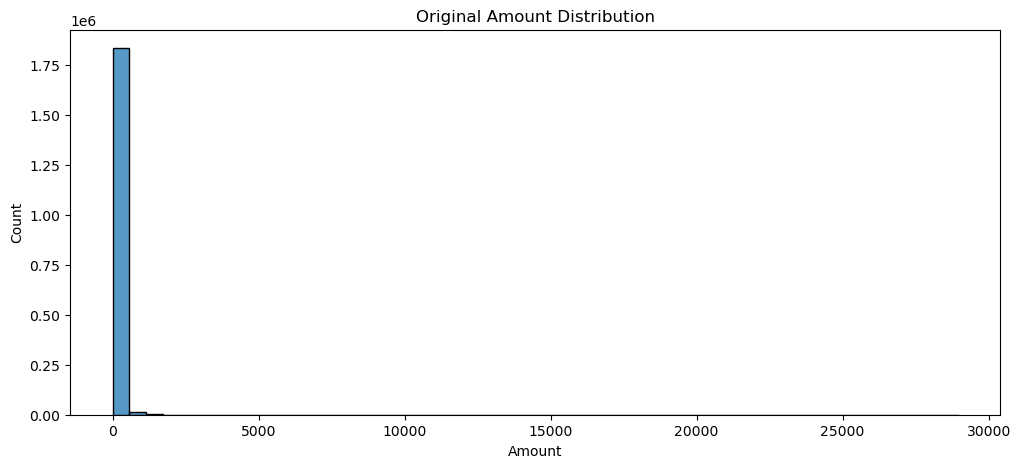

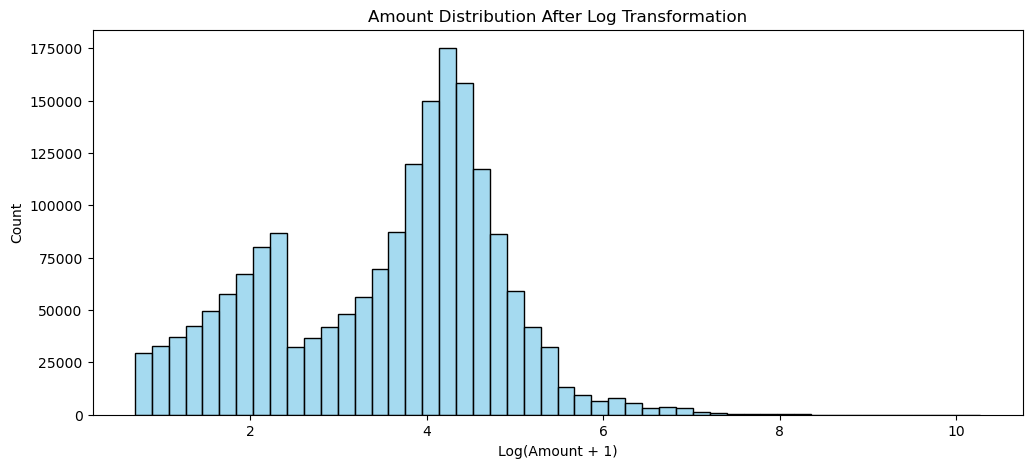

Amount statistics after log transformation:
count    1.852394e+06
mean     3.531722e+00
std      1.288350e+00
min      6.931472e-01
25%      2.364620e+00
50%      3.880532e+00
75%      4.432007e+00
max      1.027332e+01
Name: amt, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Examine the original 'amt' distribution (optional)
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='amt', bins=50, stat='count')
plt.title('Original Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

# Apply log transformation using log1p
df['amt'] = np.log1p(df['amt'])

# Plot the transformed 'amt' distribution
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='amt', bins=50, stat='count', color='skyblue')
plt.title('Amount Distribution After Log Transformation')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Count')
plt.show()

print("Amount statistics after log transformation:")
print(df['amt'].describe())

# Log Transform city_pop Before Scaling
We noticed that city_pop has high skewness and many outliers. Let's apply a log transformation to this feature before scaling.

City Population Statistics Before Log Transform:
count    1.852394e+06
mean     8.864367e+04
std      3.014876e+05
min      2.300000e+01
25%      7.410000e+02
50%      2.443000e+03
75%      2.032800e+04
max      2.906700e+06
Name: city_pop, dtype: float64

City Population Statistics After Log Transform:
count    1.852394e+06
mean     8.358653e+00
std      2.450632e+00
min      3.178054e+00
25%      6.609349e+00
50%      7.801391e+00
75%      9.919804e+00
max      1.488253e+01
Name: city_pop, dtype: float64


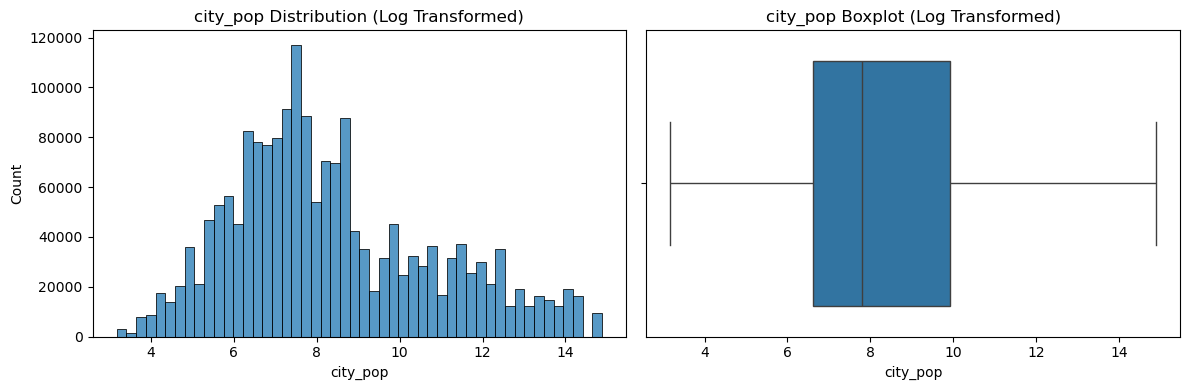

In [6]:
# Apply log transformation to city_pop
import numpy as np

print("City Population Statistics Before Log Transform:")
print(df['city_pop'].describe())

# Add a small constant (1) before log transform to handle zero values if any
df['city_pop'] = np.log1p(df['city_pop'])

print("\nCity Population Statistics After Log Transform:")
print(df['city_pop'].describe())

# Plot the distribution before and after transformation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df['city_pop'], bins=50)
plt.title('city_pop Distribution (Log Transformed)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['city_pop'])
plt.title('city_pop Boxplot (Log Transformed)')

plt.tight_layout()
plt.show()

In [7]:
print("Columns after above steps:")
print(df.columns)

Columns after above steps:
Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'trans_hour', 'trans_day', 'trans_month',
       'trans_dayofweek'],
      dtype='object')


In [8]:
# Check for missing values in each column
missing_counts = df.isnull().sum()
print("Missing values per column:")
print(missing_counts)

# For numerical columns, fill missing values with the median. (Not needed in our dataset)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill missing values with the mode. (Not needed in our dataset)
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that there are no missing values left
print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing values per column:
merchant           0
category           0
amt                0
gender             0
street             0
city               0
state              0
zip                0
lat                0
long               0
city_pop           0
job                0
merch_lat          0
merch_long         0
is_fraud           0
age                0
trans_hour         0
trans_day          0
trans_month        0
trans_dayofweek    0
dtype: int64

Missing values after imputation:
merchant           0
category           0
amt                0
gender             0
street             0
city               0
state              0
zip                0
lat                0
long               0
city_pop           0
job                0
merch_lat          0
merch_long         0
is_fraud           0
age                0
trans_hour         0
trans_day          0
trans_month        0
trans_dayofweek    0
dtype: int64


# Preparing Categorical Data for the FraudDiffuse Model
In this step, we will convert our categorical features into integer codes (indices) using pandas’ factorize method. This approach is ideal when you plan to use embedding layers within your deep learning model, as it lets the network learn a rich representation of each category. We’ll also create dictionaries that store the vocabulary sizes for each categorical feature as well as sample mappings from the original category to the integer code.

In [9]:
import pandas as pd

# Define the list of categorical columns (adjust as needed)
categorical_columns = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Initialize dictionaries to store the vocabulary sizes and the mappings from original values to indices.
cat_vocab = {}     # This will hold the number of unique elements for each categorical feature.
cat_mapping = {}   # This will hold the actual mapping from each category to its integer code.

# For each categorical column, factorize and update the DataFrame.
for col in categorical_columns:
    # factorize returns a tuple: (codes, uniques)
    codes, uniques = pd.factorize(df[col])
    df[col] = codes  # Replace the column with the factorized integer codes.
    cat_vocab[col] = len(uniques)  # Store the vocabulary size.
    # Create a mapping dictionary: original value -> integer code.
    cat_mapping[col] = {val: idx for idx, val in enumerate(uniques)}

# Print the vocabulary sizes to verify.
print("Categorical Vocabulary Sizes:")
for col, size in cat_vocab.items():
    print(f"{col}: {size}")

# Print a sample mapping (first 10 items) for each categorical column.
print("\nSample Mappings for each categorical column:")
for col in categorical_columns:
    print(f"{col}: {dict(list(cat_mapping[col].items())[:10])}")

# Finally, display the first few rows of the updated DataFrame.
print("\nDataFrame after encoding categorical features (first 5 rows):")
print(df.head())

Categorical Vocabulary Sizes:
merchant: 693
category: 14
gender: 2
street: 999
city: 906
state: 51
zip: 985
job: 497

Sample Mappings for each categorical column:
merchant: {'fraud_Rippin, Kub and Mann': 0, 'fraud_Heller, Gutmann and Zieme': 1, 'fraud_Lind-Buckridge': 2, 'fraud_Kutch, Hermiston and Farrell': 3, 'fraud_Keeling-Crist': 4, 'fraud_Stroman, Hudson and Erdman': 5, 'fraud_Rowe-Vandervort': 6, 'fraud_Corwin-Collins': 7, 'fraud_Herzog Ltd': 8, 'fraud_Schoen, Kuphal and Nitzsche': 9}
category: {'misc_net': 0, 'grocery_pos': 1, 'entertainment': 2, 'gas_transport': 3, 'misc_pos': 4, 'grocery_net': 5, 'shopping_net': 6, 'shopping_pos': 7, 'food_dining': 8, 'personal_care': 9}
gender: {'F': 0, 'M': 1}
street: {'561 Perry Cove': 0, '43039 Riley Greens Suite 393': 1, '594 White Dale Suite 530': 2, '9443 Cynthia Court Apt. 038': 3, '408 Bradley Rest': 4, '4655 David Island': 5, '889 Sarah Station Suite 624': 6, '231 Flores Pass Suite 720': 7, '6888 Hicks Stream Suite 954': 8, '21326 Ta

# Scaling Numerical Features and Splitting the Dataset
In this step, we will:  <br>
1.Identify the numeric features that are naturally continuous (such as amt, lat, long, city_pop, merch_lat, merch_long, age, and the time-derived features). <br>
2. Apply a StandardScaler to these features so that they are normalized. <br>
3. Separate the target (is_fraud) from the rest of the features. <br>
4. Split the dataset into training, validation, and test sets (using stratified splits to maintain the fraud ratio). <br>
### Note: We exclude the encoded categorical features (like merchant, category, etc.) from scaling because they represent indices for embedding layers in our model.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the numeric features that are continuous and should be scaled.
# Note: Do not include the categorical features (used for embeddings) in this list.
num_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

# Initialize and fit the scaler on these numeric features.
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Optionally, display basic statistics to verify scaling.
print("Statistics for numeric features after scaling:")
print(df[num_features].describe())

# Separate the target variable from the features.
target = 'is_fraud'
X = df.drop(columns=[target])
y = df[target]

# Split the data into training, validation, and test sets.
# Here, we perform a two-step split:
# - First, set aside 20% of the data as the test set.
# - Then, split the remaining 80% into 65% training and 15% validation.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, 
                                                            stratify=y, random_state=42)

# Out of the 80% remaining, set aside 15/80 ≈ 18.75% for validation to approximate a 65/15/20 split.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.1875, stratify=y_train_val, random_state=42)

# Print shapes to verify the splits.
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Statistics for numeric features after scaling:
                amt           lat          long      city_pop     merch_lat  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   2.450007e-16 -1.850946e-15 -6.111838e-15 -1.766159e-16  9.866081e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.203265e+00 -3.650266e+00 -5.487712e+00 -2.113985e+00 -3.821597e+00   
25%   -9.058887e-01 -7.631735e-01 -4.779037e-01 -7.138175e-01 -7.440559e-01   
50%    2.707423e-01  1.607008e-01  2.000985e-01 -2.273951e-01  1.625517e-01   
75%    6.987894e-01  6.706319e-01  7.324638e-01  6.370403e-01  6.693210e-01   
max    5.232742e+00  5.551447e+00  1.620433e+00  2.662121e+00  5.674412e+00   

         merch_long           age    trans_hour     trans_day   trans_month  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.883866e-16  5.931693e-17 -1.366161e-16  5.093953e-17 -5.005576e-16   
std 

# Saving the Processed Data

In [11]:
import joblib

# Save the processed splits to CSV files.
X_train.to_csv('Data/processed/X_train.csv', index=False)
y_train.to_csv('Data/processed/y_train.csv', index=False)

X_val.to_csv('Data/processed/X_val.csv', index=False)
y_val.to_csv('Data/processed/y_val.csv', index=False)

X_test.to_csv('Data/processed/X_test.csv', index=False)
y_test.to_csv('Data/processed/y_test.csv', index=False)

# Also, save the scaler object for later transformation during inference.
joblib.dump(scaler, 'Data/processed/standard_scaler.pkl')

print("Processed data and scaler saved successfully.")

Processed data and scaler saved successfully.


# Final Sanity Checks

In [12]:
# 1. Checking the distribution of the target variable in each split
print("Target distribution in Training set:")
print(y_train.value_counts(normalize=True))
print("\nTarget distribution in Validation set:")
print(y_val.value_counts(normalize=True))
print("\nTarget distribution in Test set:")
print(y_test.value_counts(normalize=True))

# 2. Save the categorical mapping dictionaries (if not already saved)
import joblib

# It is important to retain these mappings for later use in your model.
joblib.dump(cat_vocab, 'Data/processed/cat_vocab.pkl')
joblib.dump(cat_mapping, 'Data/processed/cat_mapping.pkl')
print("\nCategorical mapping dictionaries saved successfully.")

# 3. Display a few statistical summaries or sample rows for final verification
print("\nFinal DataFrame sample (first 5 rows):")
print(df.head())

Target distribution in Training set:
is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64

Target distribution in Validation set:
is_fraud
0    0.994789
1    0.005211
Name: proportion, dtype: float64

Target distribution in Test set:
is_fraud
0    0.994791
1    0.005209
Name: proportion, dtype: float64

Categorical mapping dictionaries saved successfully.

Final DataFrame sample (first 5 rows):
   merchant  category       amt  gender  street  city  state  zip       lat  \
0         0         0 -1.354427       0       0     0      0    0 -0.485167   
1         1         1  0.894584       0       1     1      1    1  2.040531   
2         2         2  1.449093       1       2     2      2    2  0.718034   
3         3         3  0.230465       1       3     3      3    3  1.516580   
4         4         4  0.177396       1       4     4      4    4 -0.023388   

       long  city_pop  job  merch_lat  merch_long  is_fraud       age  \
0  0.658263 -0.081317    0  -0.495080  

# Further EDA on Scaled Numeric Features

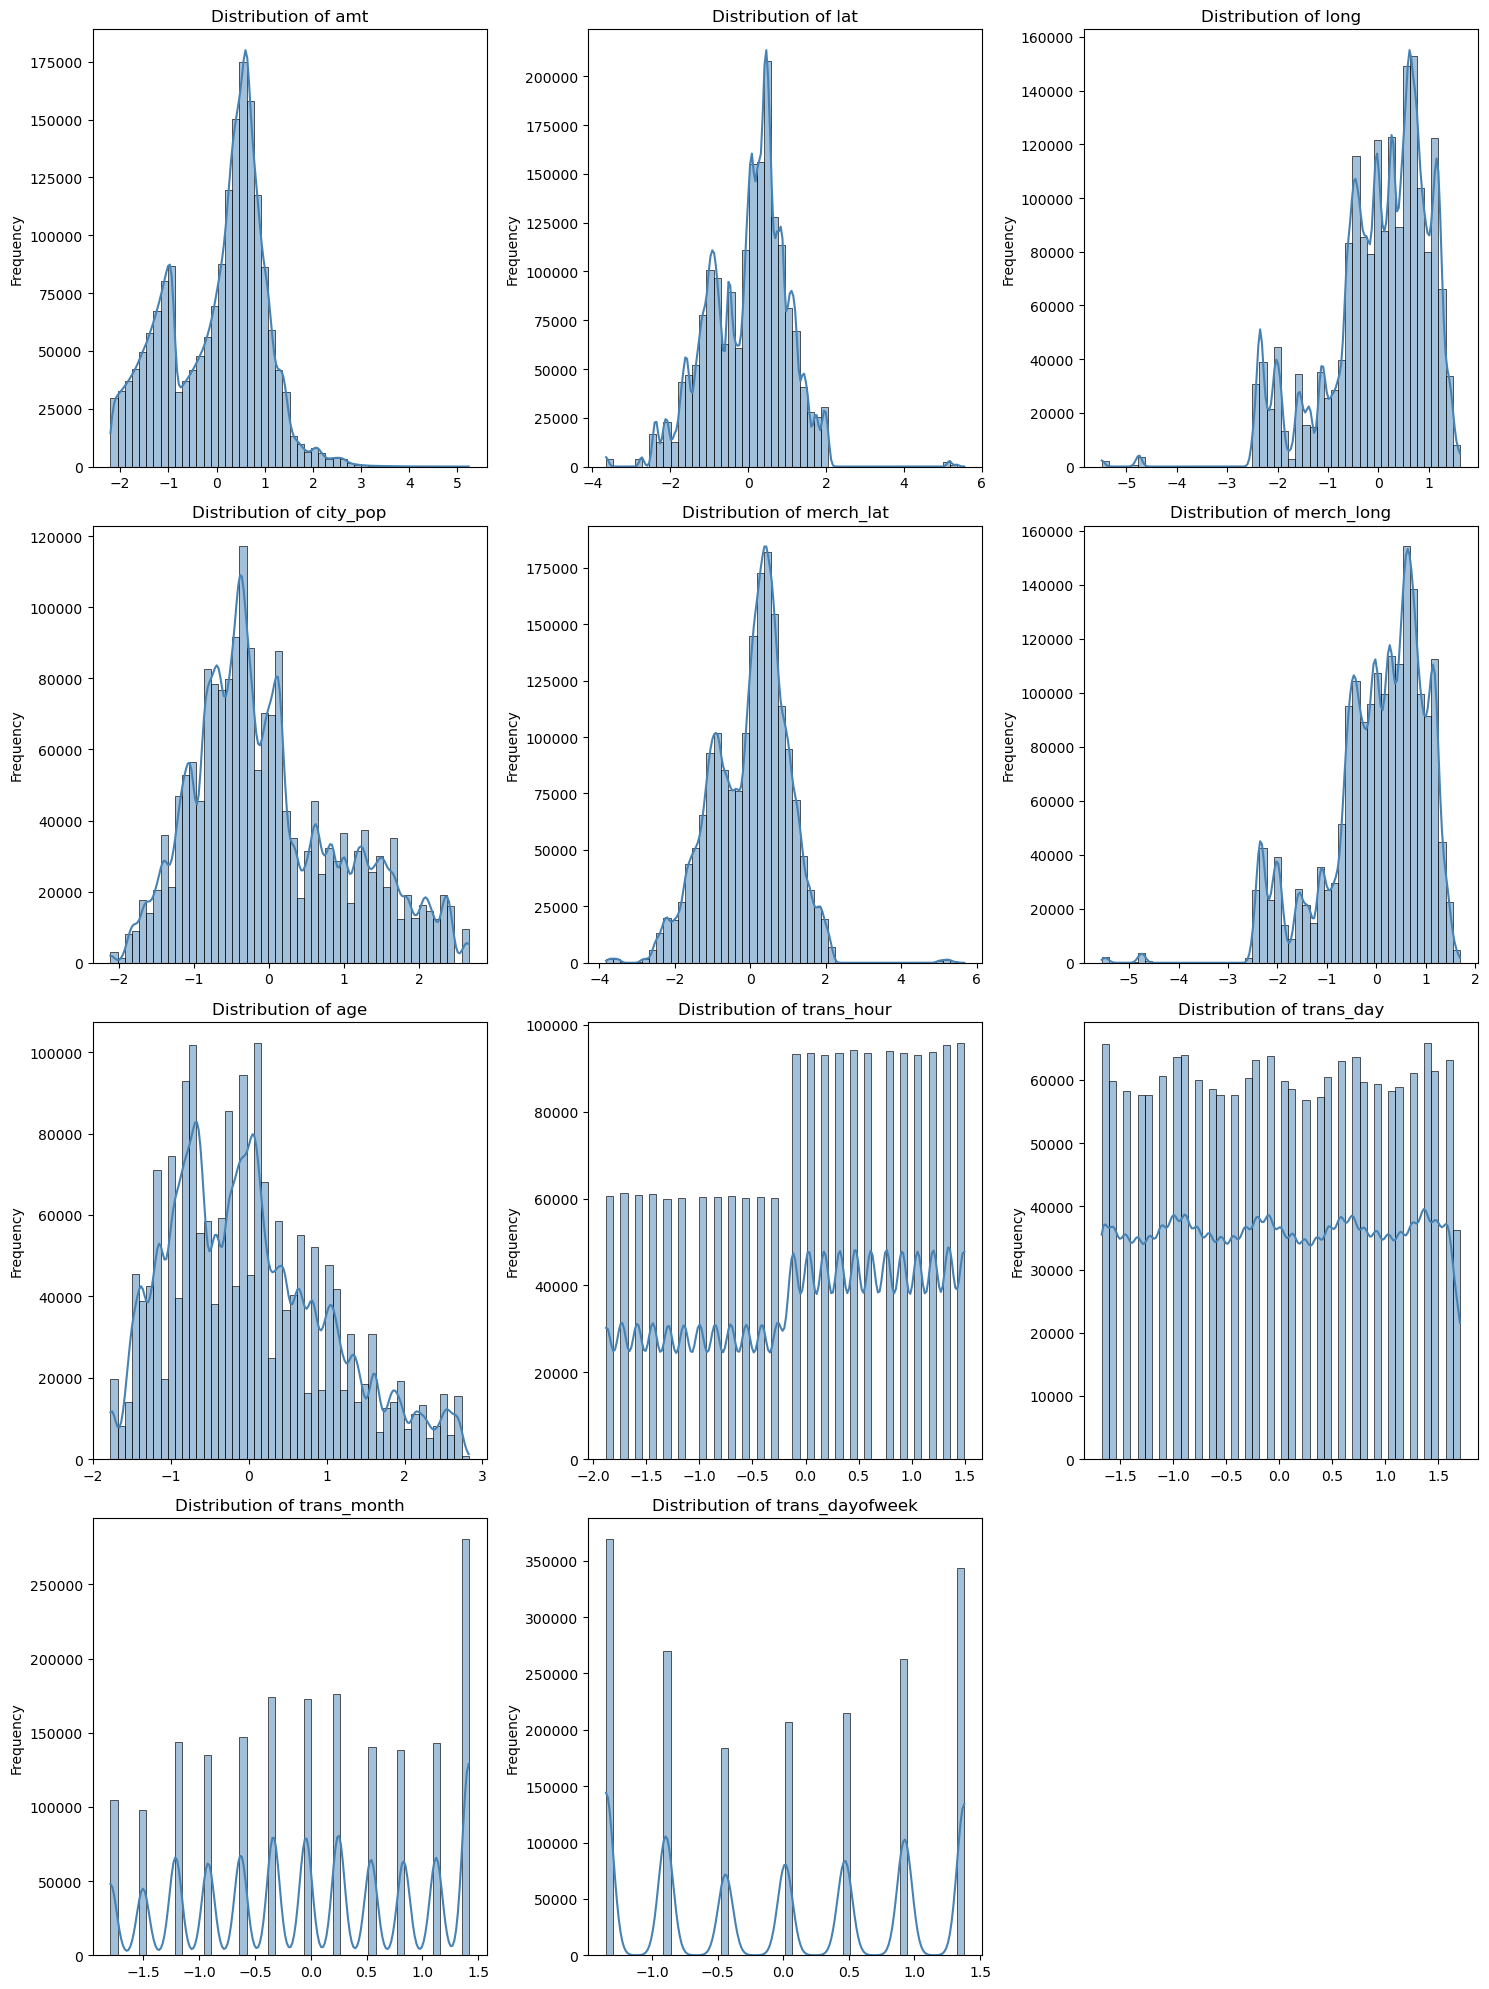

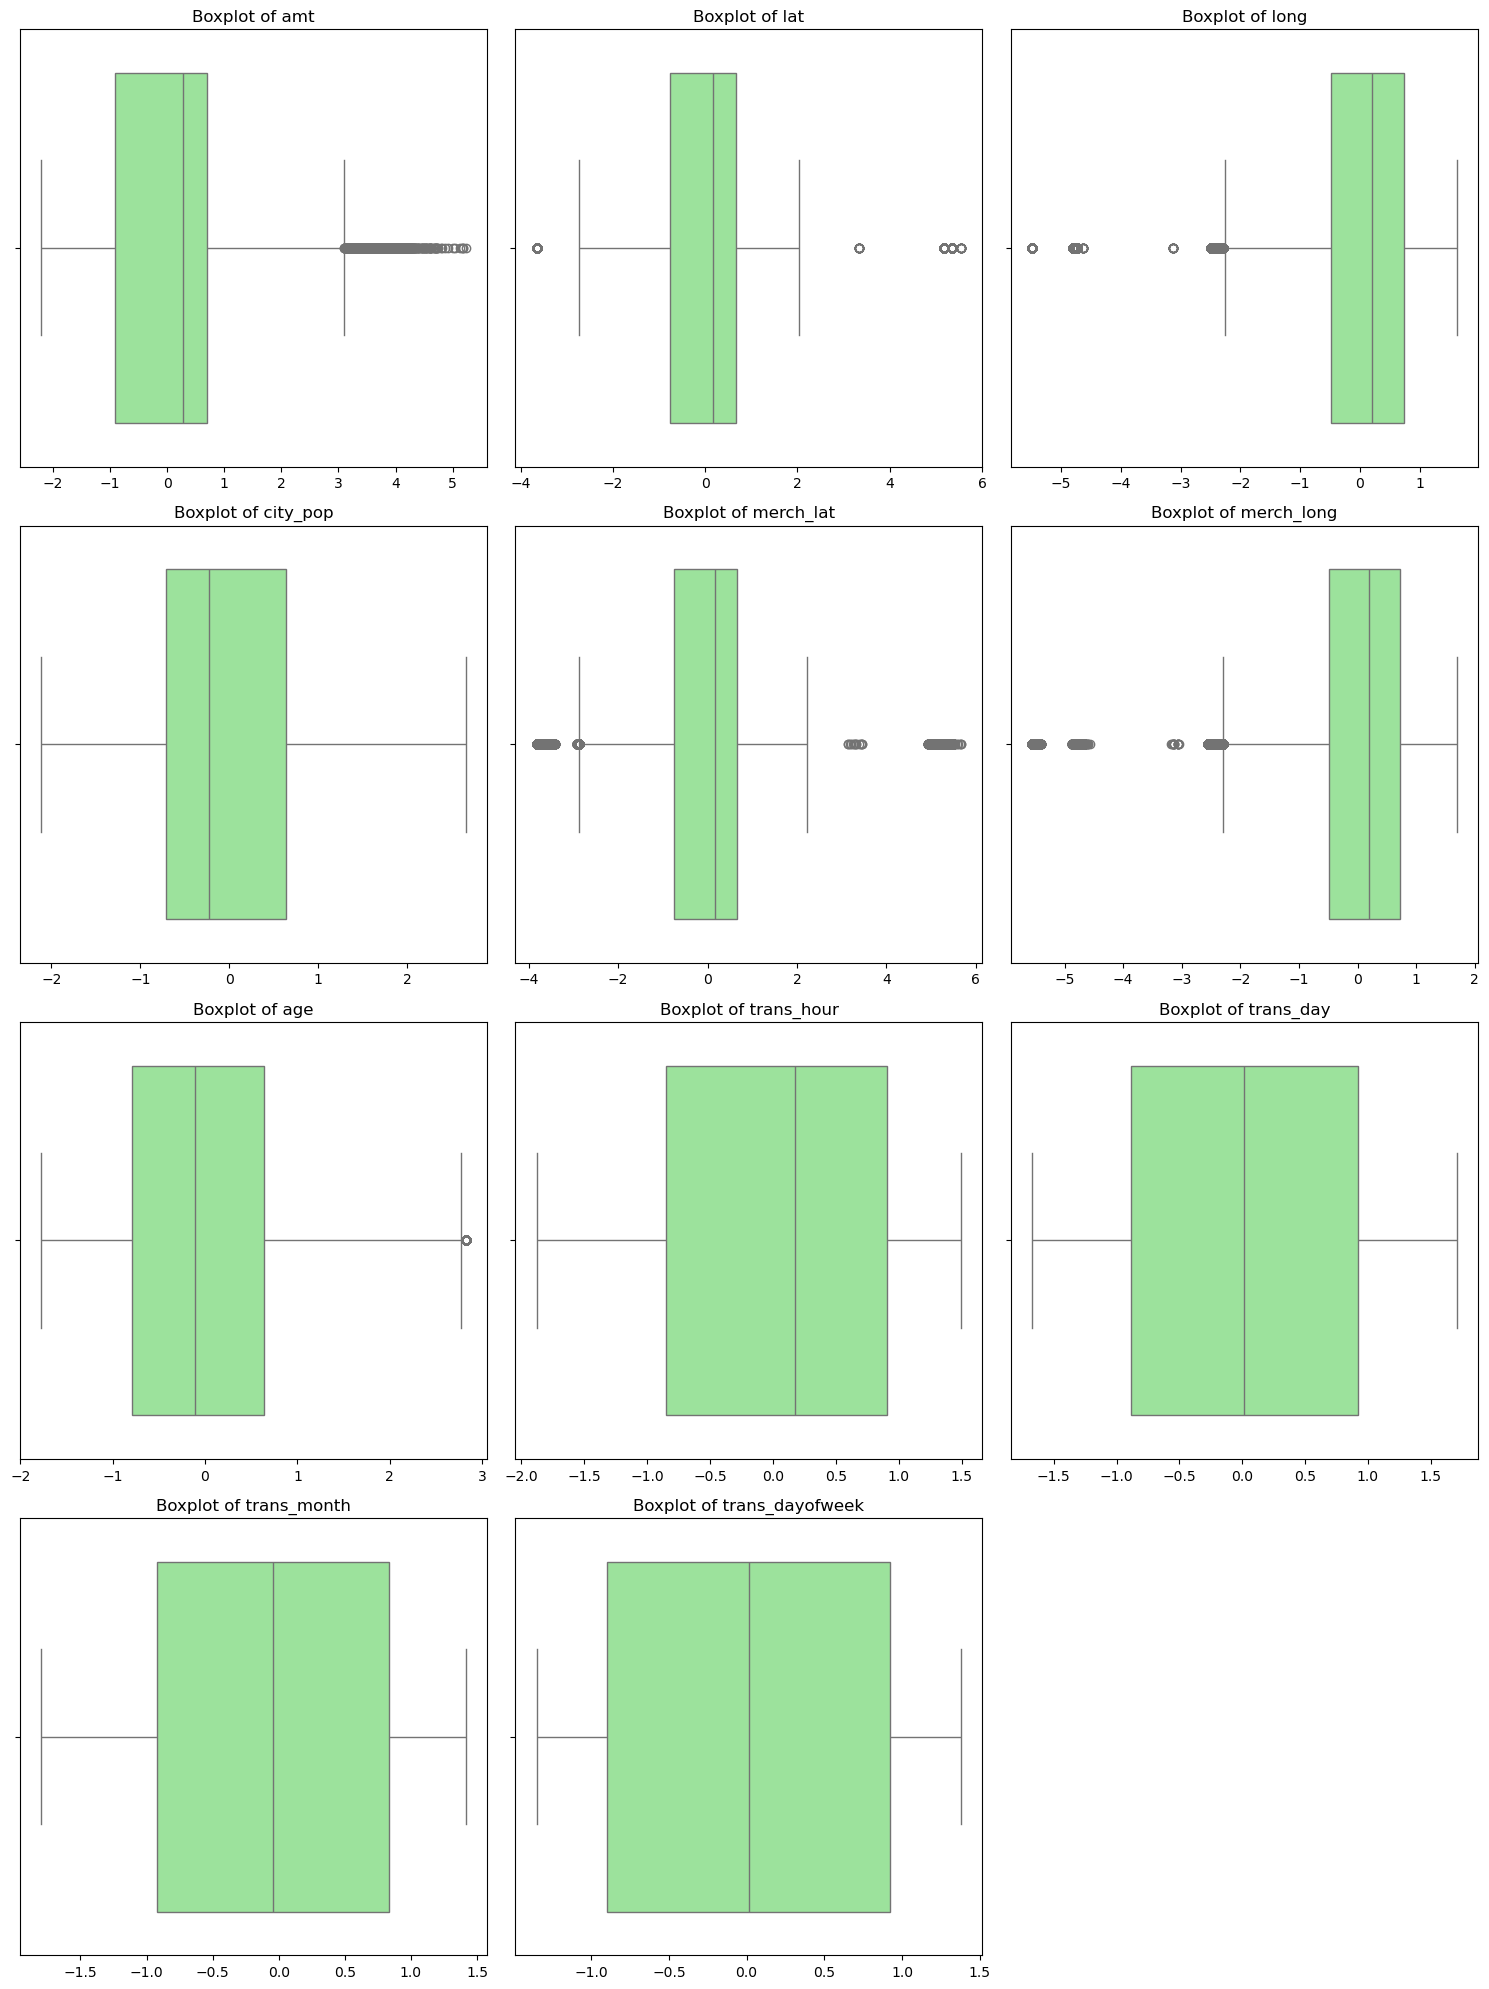

In [13]:
# List of numeric features that were scaled 
num_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

plt.figure(figsize=(15, 20))

# Plot the distribution for each numeric feature.
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], bins=50, kde=True, color='steelblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot boxplots to check for outliers.
plt.figure(figsize=(15, 20))
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.xlabel("")

plt.tight_layout()
plt.show()

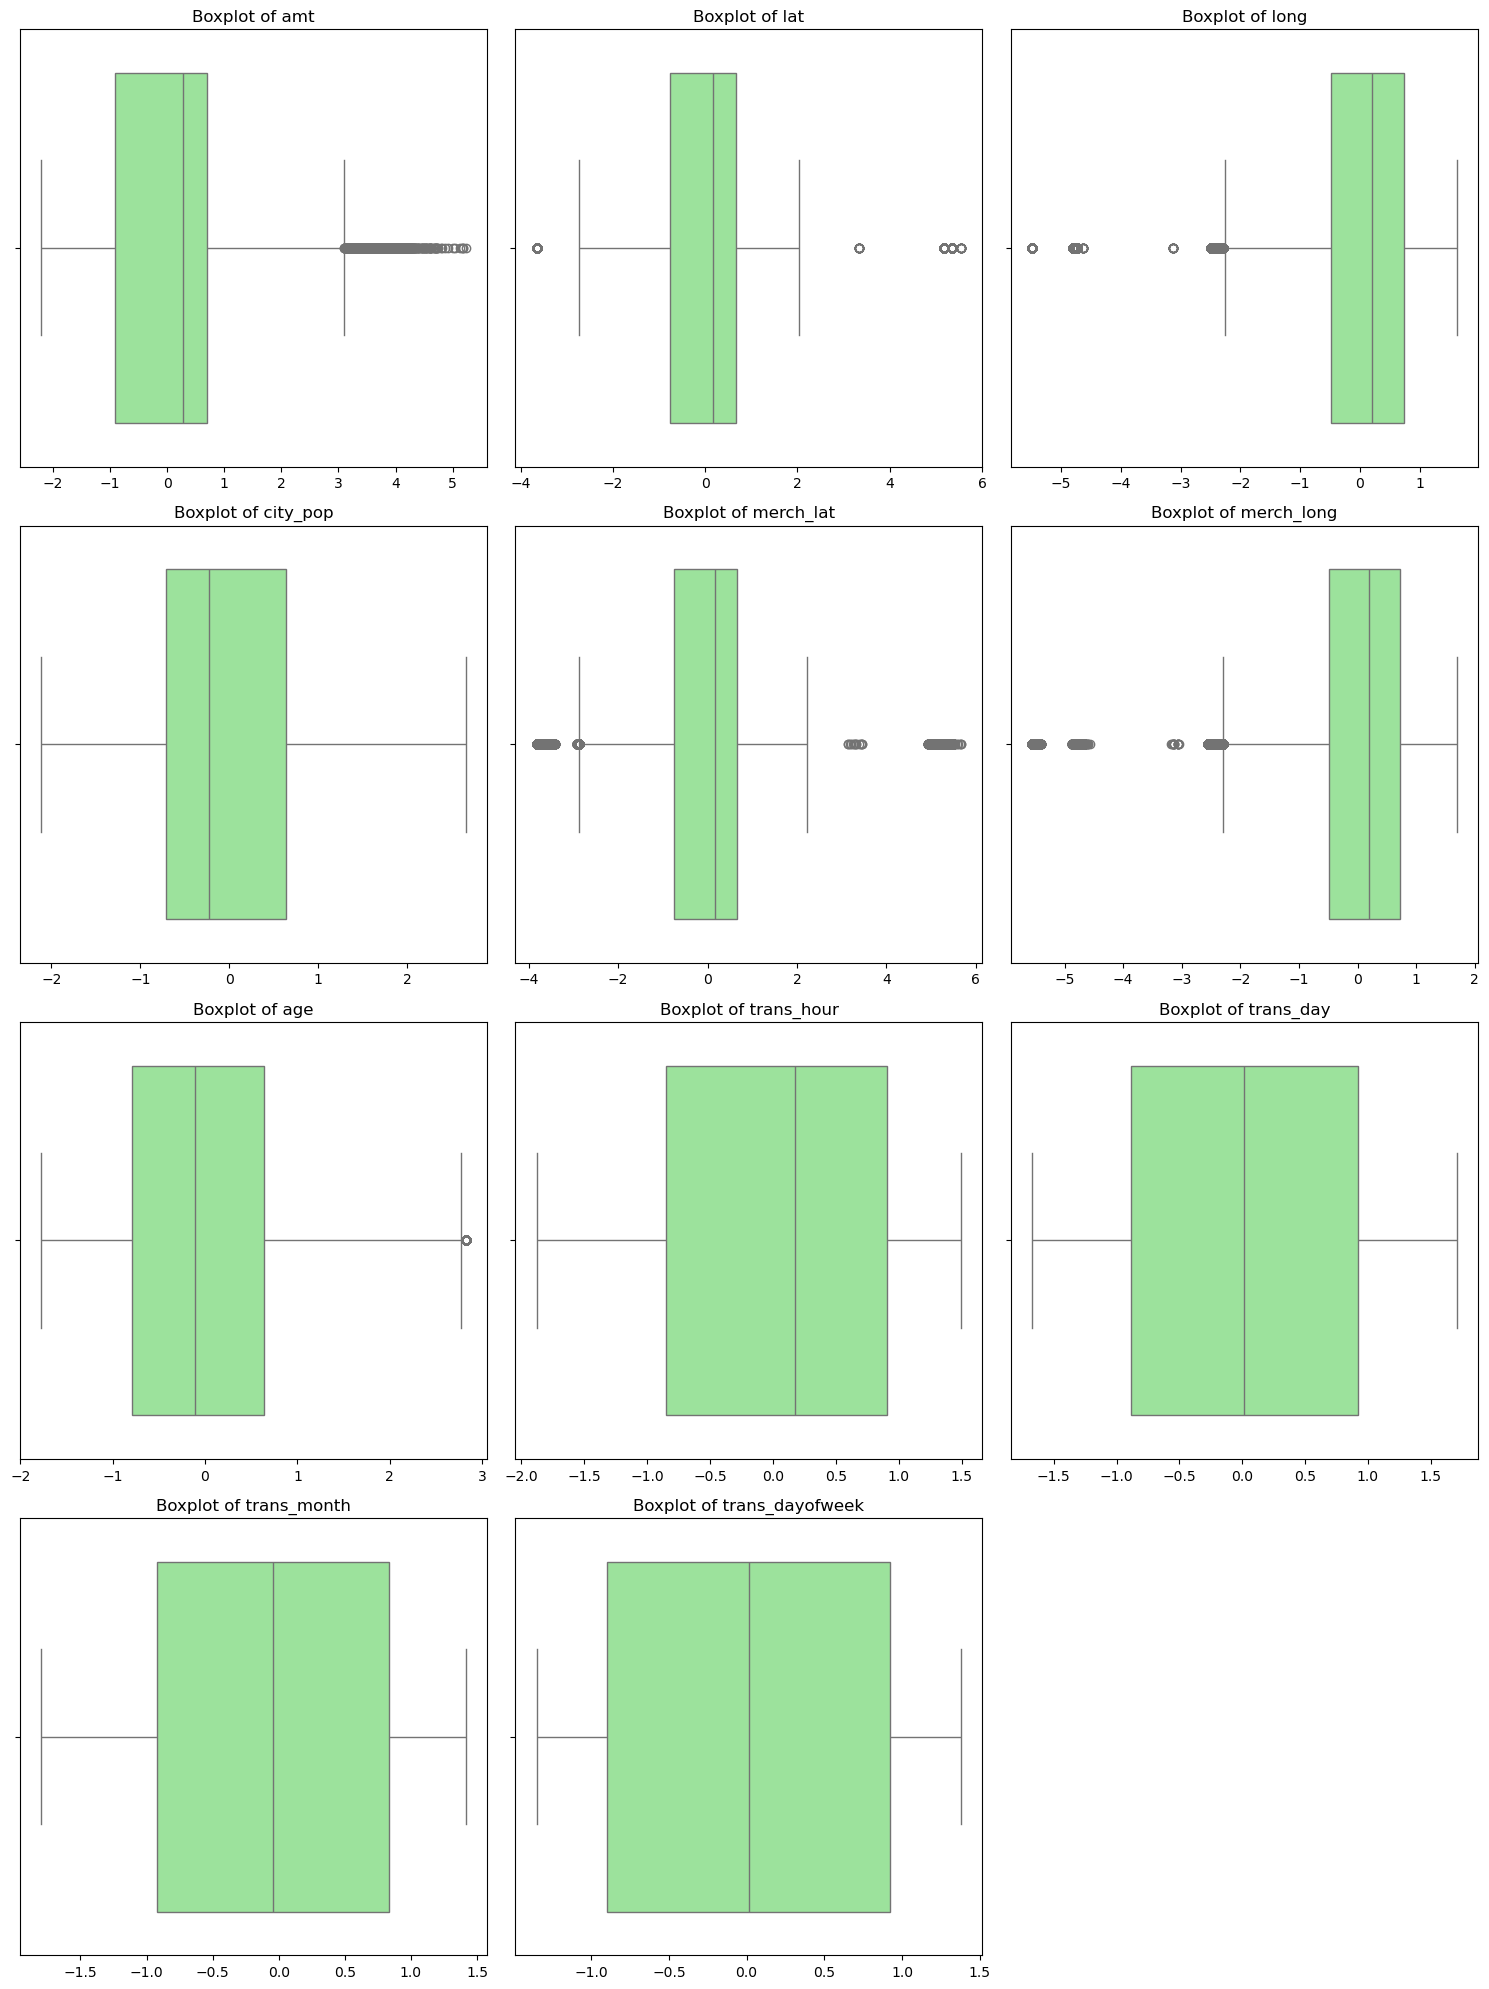

Detailed Statistics for Scaled Numeric Features:
--------------------------------------------------------------------------------

Feature: amt
Count: 1,852,394
Mean: 0.000000
Std: 1.000000
Min: -2.203265
25th percentile: -0.905889
Median: 0.270742
75th percentile: 0.698789
Max: 5.232742
IQR: 1.604678
Skewness: -0.302557
Kurtosis: -0.530740
Number of outliers: 1,220 (0.07% of data)
--------------------------------------------------------------------------------

Feature: lat
Count: 1,852,394
Mean: -0.000000
Std: 1.000000
Min: -3.650266
25th percentile: -0.763174
Median: 0.160701
75th percentile: 0.670632
Max: 5.551447
IQR: 1.433805
Skewness: -0.191999
Kurtosis: 0.791077
Number of outliers: 6,612 (0.36% of data)
--------------------------------------------------------------------------------

Feature: long
Count: 1,852,394
Mean: -0.000000
Std: 1.000000
Min: -5.487712
25th percentile: -0.477904
Median: 0.200098
75th percentile: 0.732464
Max: 1.620433
IQR: 1.210367
Skewness: -1.146919
Kur

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# List of numeric features that were scaled 
num_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

# Create boxplots
plt.figure(figsize=(15, 20))
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.xlabel("")

plt.tight_layout()
plt.show()

# Print detailed statistics for each feature
print("Detailed Statistics for Scaled Numeric Features:")
print("-" * 80)
for col in num_features:
    stats = df[col].describe()
    iqr = stats['75%'] - stats['25%']
    skew = df[col].skew()
    kurtosis = df[col].kurtosis()
    
    print(f"\nFeature: {col}")
    print(f"Count: {stats['count']:,.0f}")
    print(f"Mean: {stats['mean']:.6f}")
    print(f"Std: {stats['std']:.6f}")
    print(f"Min: {stats['min']:.6f}")
    print(f"25th percentile: {stats['25%']:.6f}")
    print(f"Median: {stats['50%']:.6f}")
    print(f"75th percentile: {stats['75%']:.6f}")
    print(f"Max: {stats['max']:.6f}")
    print(f"IQR: {iqr:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Kurtosis: {kurtosis:.6f}")
    
    # Calculate number of outliers
    lower_bound = stats['25%'] - 1.5 * iqr
    upper_bound = stats['75%'] + 1.5 * iqr
    n_outliers = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    print(f"Number of outliers: {n_outliers:,} ({(n_outliers/len(df)*100):.2f}% of data)")
    print("-" * 80)